<a href="https://colab.research.google.com/github/pramodh-1612/Model-Zoo/blob/master/ResNet_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch 
import numpy as np
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torchsummary import summary
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
import time
from sklearn.metrics import confusion_matrix 
import pandas as pd

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
class BasicModule(nn.Module):
    """
    basic block with identity maps in shortcuts
    """
    def __init__(self, in_planes,out_planes, stride = 1):
        
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, out_planes, 3, padding=1, bias=False, stride=stride)
        self.bn1 = nn.BatchNorm2d(out_planes)
        self.conv2 = nn.Conv2d(out_planes, out_planes, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        
        self.shortcut = nn.Sequential()
        if stride!=1 or in_planes!=out_planes :
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1, stride = stride, bias=False),
                nn.BatchNorm2d(out_planes)
            )
        
    
    def forward(self, x):
        
        added = x
        
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.bn2(self.conv2(x))
        x += self.shortcut(added)
        return F.relu(x)


In [0]:
class BottleNeckModule(nn.Module):
    """
    basic block with identity maps in shortcuts
    """
    def __init__(self, in_planes,out_planes, stride = 1):
        
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, out_planes, 1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(out_planes)
        self.conv2 = nn.Conv2d(out_planes, out_planes, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.conv3 = nn.Conv2d(out_planes, out_planes, 1, padding=0, bias=False, stride=stride)
        self.bn3 = nn.BatchNorm2d(out_planes)

        self.shortcut = nn.Sequential()
        if stride!=1 or in_planes!=out_planes:

          self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1, stride = stride, bias=False),
                nn.BatchNorm2d(out_planes)
            
            )
    def forward(self, x):
        
        added = x
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        inter = self.shortcut(added)
        x +=inter
        return F.relu(x)

In [0]:
class ResNet(nn.Module):

  def __init__(self,block,filter_map,n,num_classes=10):

    super().__init__()

    self.conv1  = nn.Conv2d(in_channels=3,out_channels=filter_map[0],kernel_size=3,padding=1,bias=False)
    self.bn1 = nn.BatchNorm2d(filter_map[0])

    self.block1 = self.MakeResNetLayer(block,filter_map[0],n,stride=1)
    self.block2 = self.MakeResNetLayer(block,(filter_map[0],filter_map[1]),n,stride=2)
    self.block3 = self.MakeResNetLayer(block,(filter_map[1],filter_map[2]),n,stride=2)

    self.globalavgpool = nn.AdaptiveAvgPool2d(2)
    self.fc = nn.Linear(2*2*filter_map[2],num_classes)  

  def MakeResNetLayer(self,block,filters,n,stride):

    if stride!=1 :
      in_planes,out_planes = filters
    else :
      in_planes,out_planes = filters,filters

    layer = []
    layer.append(block(in_planes,out_planes,stride))

    for i in range(n-1):

      layer.append(block(out_planes, out_planes))

    SubBlock = nn.Sequential(*layer)

    return SubBlock

  def  forward(self,x):

    x = F.relu(self.bn1(self.conv1(x)))
        
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
        
    x = self.globalavgpool(x)
    x = x.view(-1, self.find_shape(x))
    x = self.fc(x)
    x = F.softmax(x, dim =1)
    return x

  def find_shape(self, x):
    res = 1
    for dim in x[0].shape:
        res *= dim
    return res          

In [5]:
batch_size = 100

transform  = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean=(0,0,0),std=(1,1,1))])

trainset = torchvision.datasets.CIFAR10(root = './data', download = True, train = True, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root = './data', download = True, train = False, transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle = True, num_workers=2)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
print(trainset)
print(testset)
print(len(trainloader))
print(len(testloader))

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0, 0, 0), std=(1, 1, 1))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0, 0, 0), std=(1, 1, 1))
           )
500
100


In [0]:
modelbasic = ResNet(BasicModule, [16,32,64], 5)
modelbottleneck = ResNet(BottleNeckModule, [16,32,64], 5)

In [0]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [9]:
device = 'cuda'
modelbasic.to(device)
modelbottleneck.to(device)
summary(modelbasic,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
            Conv2d-3           [-1, 16, 32, 32]           2,304
       BatchNorm2d-4           [-1, 16, 32, 32]              32
            Conv2d-5           [-1, 16, 32, 32]           2,304
       BatchNorm2d-6           [-1, 16, 32, 32]              32
       BasicModule-7           [-1, 16, 32, 32]               0
            Conv2d-8           [-1, 16, 32, 32]           2,304
       BatchNorm2d-9           [-1, 16, 32, 32]              32
           Conv2d-10           [-1, 16, 32, 32]           2,304
      BatchNorm2d-11           [-1, 16, 32, 32]              32
      BasicModule-12           [-1, 16, 32, 32]               0
           Conv2d-13           [-1, 16, 32, 32]           2,304
      BatchNorm2d-14           [-1, 16,

In [10]:
summary(modelbottleneck,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
            Conv2d-3           [-1, 16, 32, 32]             256
       BatchNorm2d-4           [-1, 16, 32, 32]              32
            Conv2d-5           [-1, 16, 32, 32]           2,304
       BatchNorm2d-6           [-1, 16, 32, 32]              32
            Conv2d-7           [-1, 16, 32, 32]             256
       BatchNorm2d-8           [-1, 16, 32, 32]              32
  BottleNeckModule-9           [-1, 16, 32, 32]               0
           Conv2d-10           [-1, 16, 32, 32]             256
      BatchNorm2d-11           [-1, 16, 32, 32]              32
           Conv2d-12           [-1, 16, 32, 32]           2,304
      BatchNorm2d-13           [-1, 16, 32, 32]              32
           Conv2d-14           [-1, 16,

In [0]:
epochs = 90
learning_rate = 0.01
criterion = nn.CrossEntropyLoss()


In [13]:
print('test and training loss/accuracy for basic model')
modelbasic.train()

optimizer = torch.optim.Adam(modelbasic.parameters(), lr = learning_rate)


start_time = time.time()

epochs = 80
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(trainloader):
        b+=1
        
        # Apply the model
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        y_pred = modelbasic(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%500 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{100*b:6}/50000]  loss: {loss.item():10.8f}   accuracy: {batch_corr.item()}%')
        
    train_losses.append(loss.item())
    train_correct.append(trn_corr.item())
    
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(testloader):
          
            X_test = X_test.to(device)
            y_test = y_test.to(device)
            # Apply the model
            y_val = modelbasic(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss.item())
    test_correct.append(tst_corr.item())
        
print(f'\nDuration: {(time.time() - start_time)/60} minutes') # print the time elapsed  ,minutes') # print the time elapsed 
train_loss_basic = np.array(train_losses)
test_loss_basic = np.array(test_losses)

test and training loss/accuracy for basic model
epoch:  0  batch:  500 [ 50000/50000]  loss: 1.94029331   accuracy: 51%
epoch:  1  batch:  500 [ 50000/50000]  loss: 1.89990652   accuracy: 57%
epoch:  2  batch:  500 [ 50000/50000]  loss: 1.93451250   accuracy: 52%
epoch:  3  batch:  500 [ 50000/50000]  loss: 1.94600224   accuracy: 50%
epoch:  4  batch:  500 [ 50000/50000]  loss: 1.79265320   accuracy: 66%
epoch:  5  batch:  500 [ 50000/50000]  loss: 1.78732252   accuracy: 67%
epoch:  6  batch:  500 [ 50000/50000]  loss: 1.77689135   accuracy: 70%
epoch:  7  batch:  500 [ 50000/50000]  loss: 1.68557775   accuracy: 77%
epoch:  8  batch:  500 [ 50000/50000]  loss: 1.72878277   accuracy: 75%
epoch:  9  batch:  500 [ 50000/50000]  loss: 1.77080917   accuracy: 68%
epoch: 10  batch:  500 [ 50000/50000]  loss: 1.74841380   accuracy: 70%
epoch: 11  batch:  500 [ 50000/50000]  loss: 1.73090971   accuracy: 73%
epoch: 12  batch:  500 [ 50000/50000]  loss: 1.81161153   accuracy: 66%
epoch: 13  batch

In [16]:
print('test and training loss/accuracy for bottleneck model')
modelbottleneck.train()

optimizer = torch.optim.Adam(modelbottleneck.parameters(), lr = learning_rate)
  
start_time = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(trainloader):
        b+=1
        
        # Apply the model
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        y_pred = modelbottleneck(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%500 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{100*b:6}/50000]  loss: {loss.item():10.8f}   accuracy: {batch_corr.item()}%')
        
    train_losses.append(loss.item())
    train_correct.append(trn_corr.item())
    

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(testloader):
          
            X_test = X_test.to(device)
            y_test = y_test.to(device)
            # Apply the model
            y_val = modelbottleneck(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss.item())
    test_correct.append(tst_corr.item())
        
print(f'\nDuration: {(time.time() - start_time)/60} minutes') # print the time elapsed  ,minutes') # print the time elapsed 
train_loss_bottleneck = np.array(train_losses)
test_loss_bottleneck = np.array(test_losses)

test and training loss/accuracy for bottleneck model
epoch:  0  batch:  500 [ 50000/50000]  loss: 1.71462393   accuracy: 74%


KeyboardInterrupt: ignored

Text(0, 0.5, 'Loss')

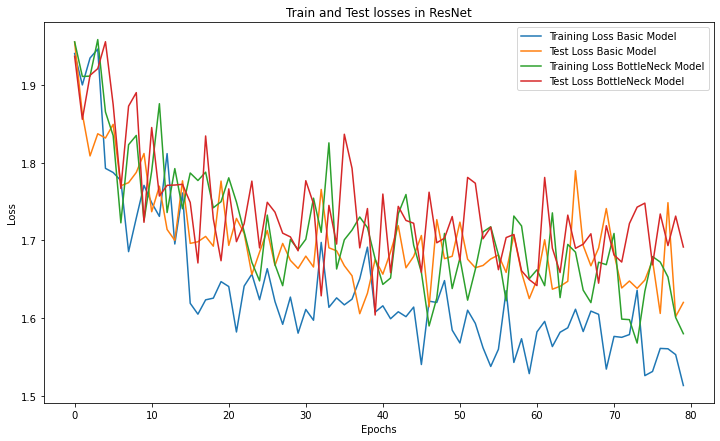

In [26]:
plt.figure(figsize=(12,7))
plt.title("Train and Test losses in ResNet")
palette_basic = sns.color_palette(palette="muted",n_colors=2)
palette_bottleneck = sns.color_palette(palette="dark",n_colors=2)
sns.lineplot(data = train_loss_basic,label="Training Loss Basic Model",palette=palette_basic)
sns.lineplot(data = test_loss_basic,label="Test Loss Basic Model",palette=palette_basic)
sns.lineplot(data = train_loss_bottleneck,label="Training Loss BottleNeck Model",palette=palette_bottleneck)
sns.lineplot(data = test_loss_bottleneck,label="Test Loss BottleNeck Model",palette=palette_bottleneck)
plt.xlabel("Epochs")
plt.ylabel("Loss")

Test accuracy Basic: 7990/10000 =  79.900%


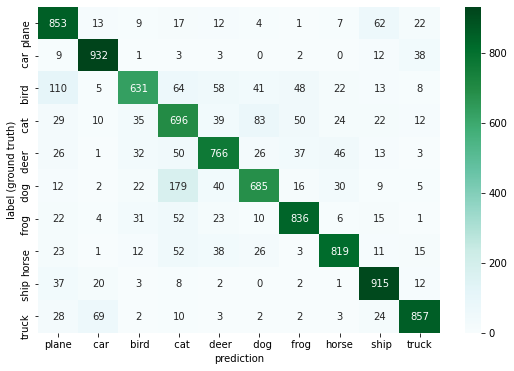

Test accuracy BottleNeck: 7701/10000 =  77.010%


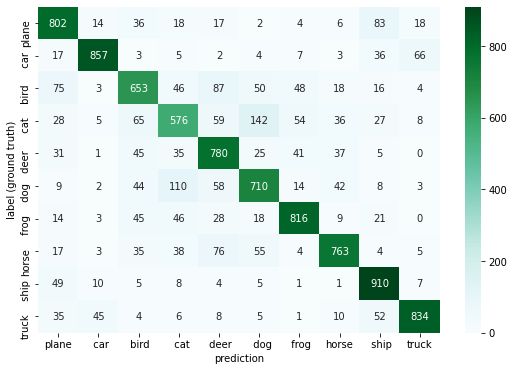

In [27]:
test_load_all = torch.utils.data.DataLoader(testset, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        y_val = modelbasic(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
        
print(f'Test accuracy Basic: {correct.item()}/{len(testset)} = {correct.item()*100/(len(testset)):7.3f}%')

class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']
arr = confusion_matrix(y_test.view(-1).cpu(), predicted.view(-1).cpu())
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

test_load_all = torch.utils.data.DataLoader(testset, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        y_val = modelbottleneck(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
        
print(f'Test accuracy BottleNeck: {correct.item()}/{len(testset)} = {correct.item()*100/(len(testset)):7.3f}%')

arr = confusion_matrix(y_test.view(-1).cpu(), predicted.view(-1).cpu())
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()
